## Agent wydawca

### Instalacja bibliotek

In [39]:
%%capture --no-stderr
%pip install -U langgraph langgraph-supervisor langchain-tavily "langchain[openai]"

In [40]:
from dotenv import load_dotenv
load_dotenv()

True

In [41]:
from langchain_tavily import TavilySearch

# klucz API Tavily: https://app.tavily.com/
web_search = TavilySearch(max_results=3)
web_search_results = web_search.invoke("Kto jest premierem Polski?")

print(web_search_results["results"][0]["content"])

W Polsce oficjalnym tytułem premiera (szefa rządu) od 1921 roku (tj. od wejścia w życie części przepisów Konstytucji marcowej) jest prezes Rady Ministrów.


### Funkcje pomocnicze

In [42]:
import json

def pretty_print_messages(update):
    print(json.dumps(update, indent=2, ensure_ascii=False))


def _name_and_content(msg):
    if isinstance(msg, dict):
        return msg.get("name", msg.get("role", "user")), msg.get("content", str(msg))
    if isinstance(msg, BaseMessage):
        name = getattr(msg, "name", None) or getattr(msg, "type", "user")
        return name, msg.content
    return "user", str(msg)


### Agent researcher

In [43]:
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

def research_agent_node(state):
    messages = state["messages"]
    user_request = messages[0].content

    search_results = web_search.invoke(user_request)
    research_content = []
    for result in search_results["results"][:3]:
        research_content.append(f"Źródło: {result['url']}\nTreść: {result['content']}\n")
    research_text = "\n---\n".join(research_content)

    research_prompt = ChatPromptTemplate.from_messages([
        ("system", """Jesteś Researcherem. Masz dostęp do fragmentów z 'wyszukiwarki' (RESEARCH).
Twoim celem jest dostarczyć rzeczowe, krótkie fakty i dane wspierające temat.
Odnoś się do fragmentów i nie fantazjuj. Pisz po polsku, zwięźle.
Po tym jak skończysz swoje zadanie odpowiedz bezpośrednio do moderatora.
Odpowiadaj używając tylko rezultatów swojej pracy, nie załączaj tekstu."""),
        ("user", "Temat: {topic}\n\nWyniki wyszukiwania:\n{research_data}")
    ])

    model = ChatOpenAI(model="gpt-4", temperature=0)
    chain = research_prompt | model | StrOutputParser()
    response = chain.invoke({"topic": user_request, "research_data": research_text})

    return {"messages": [{"role": "assistant", "content": response, "name": "research_agent"}]}


### Agent autor

In [44]:
from langchain_core.messages import BaseMessage

def _name_and_content(msg):
    if isinstance(msg, dict):
        return msg.get("name", msg.get("role", "user")), msg.get("content", str(msg))
    if isinstance(msg, BaseMessage):
        name = getattr(msg, "name", None) or getattr(msg, "type", "user")
        return name, msg.content
    # fallback
    return "user", str(msg)


In [45]:
def author_agent_node(state):
    messages = state["messages"]
    has_critic_already_intervened = state.get("critic_marked", False)

    if has_critic_already_intervened:
        author_prompt = ChatPromptTemplate.from_messages([
            ("system", """Jesteś Ekspertem-Edytorem. Otrzymałeś już feedback od Krytyka i musisz poprawić swój tekst.
Przeanalizuj uwagi krytyka i dostarcz poprawioną wersję artykułu, która odpowiada na jego zastrzeżenia.
Uwzględnij wszystkie sugestie i wypełnij wskazane luki. Pisz po polsku, konkretnie.
Po tym jak skończysz swoje zadanie odpowiedz bezpośrednio do moderatora.
Odpowiadaj używając tylko rezultatów swojej pracy, nie załączaj tekstu."""),
            ("user", "Historia konwersacji:\n{conversation_history}\n\nPopraw artykuł uwzględniając feedback krytyka.")
        ])
    else:
        author_prompt = ChatPromptTemplate.from_messages([
            ("system", """Jesteś Ekspertem. Z dostępnych faktów zaproponuj praktyczne rozwiązanie/plan.
Uwzględnij kroki, wymagania i minimalny zestaw decyzji. Pisz po polsku, konkretnie.
Po tym jak skończysz swoje zadanie odpowiedz bezpośrednio do moderatora.
Odpowiadaj używając tylko rezultatów swojej pracy, nie załączaj tekstu."""),
            ("user", "Na podstawie researchu stwórz artykuł:\n{conversation_history}")
        ])

    conversation_history = "\n".join(
        f"{_name_and_content(m)[0]}: {_name_and_content(m)[1]}"
        for m in messages
    )

    model = ChatOpenAI(model="gpt-4", temperature=0)
    chain = author_prompt | model | StrOutputParser()
    response = chain.invoke({"conversation_history": conversation_history})

    return {"messages": [{"role": "assistant", "content": response, "name": "author_agent"}]}


### Agent krytyk

In [46]:
def critic_agent_node(state):
    messages = state["messages"]

    conversation_history = "\n".join(
        f"{_name_and_content(m)[0]}: {_name_and_content(m)[1]}"
        for m in messages
    )

    critic_prompt = ChatPromptTemplate.from_messages([
        ("system", """Jesteś Krytykiem. Twoją rolą jest znaleźć luki, ryzyka i niejasności w propozycji.
Zadawaj dociekliwe pytania i wskaż brakujące elementy. Bądź konstruktywny.
Po przeanalizowaniu pracy autora, jeśli widzisz istotne braki lub problemy, zakończ swoją odpowiedź słowami: "needs improvement"
Jeśli praca jest zadowalająca i nie wymaga istotnych poprawek, zakończ słowami: "approved"
Po tym jak skończysz swoje zadanie odpowiedz bezpośrednio do moderatora.
Odpowiadaj używając tylko rezultatów swojej pracy, nie załączaj tekstu."""),
        ("user", "Przeanalizuj pracę autora:\n{conversation_history}")
    ])

    model = ChatOpenAI(model="gpt-4", temperature=0)
    chain = critic_prompt | model | StrOutputParser()
    response = chain.invoke({"conversation_history": conversation_history})

    updates = {
        "messages": [{"role": "assistant", "content": response, "name": "critic_agent"}]
    }
    if not state.get("critic_marked", False):
        updates["critic_marked"] = True  # pierwsza ingerencja krytyka

    return updates


def should_continue(state):
    last = state["messages"][-1]
    _, content = _name_and_content(last)
    content = content.lower()
    return "author_agent" if "needs improvement" in content else "end"

In [47]:
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class WorkflowState(TypedDict):
    messages: Annotated[list, add_messages]
    critic_marked: bool

supervisor = (
    StateGraph(WorkflowState)
    .add_node("research_agent", research_agent_node)
    .add_node("author_agent", author_agent_node)
    .add_node("critic_agent", critic_agent_node)
    .add_edge(START, "research_agent")
    .add_edge("research_agent", "author_agent")
    .add_edge("author_agent", "critic_agent")
    .add_conditional_edges("critic_agent", should_continue, {
        "author_agent": "author_agent",
        "end": END
    })
    .compile()
)


### Wyświetl graf

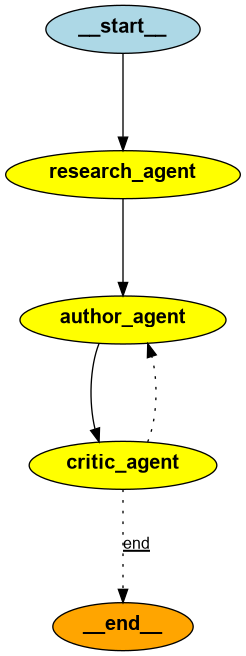

In [48]:
from IPython.display import display, Image

display(Image(supervisor.get_graph().draw_png()))

### Uruchom graf i wygeneruj artykuł

In [49]:
for chunk in supervisor.stream(
    {
        "messages": [{
            "role": "user",
            "content": "Wygeneruj artykuł na temat: Jak zbudować aplikację agenta 'Wydawcy' w oparciu o bibliotekę LangGraph",
        }],
        "critic_marked": False,
    },
    subgraphs=True,
):
    pretty_print_messages(chunk)


[
  [],
  {
    "research_agent": {
      "messages": [
        {
          "role": "assistant",
          "content": "1. LangGraph to zaawansowany framework do budowy systemów agentów AI, który oferuje większą kontrolę i skalowalność niż inne narzędzia, takie jak LangChain czy LlamaIndex. Jest to narzędzie profesjonalne, które pozwala na budowę skomplikowanych i dobrze przemyślanych agentów AI (źródło: https://www.youtube.com/watch?v=1w5cCXlh7JQ).\n\n2. LangGraph umożliwia implementację różnych wzorców dla agentów i przepływów pracy. Wyróżnia się między innymi wzorcem łańcucha podpowiedzi, paralelizacji, routingu z LLM, wzorcem orkiestratora-pracownika oraz wzorcem ewaluatora-optymalizatora. Każdy z tych wzorców ma swoje specyficzne zastosowania i może być efektywnie zaimplementowany za pomocą LangGraph (źródło: https://www.youtube.com/watch?v=aHCDrAbH_go).\n\n3. LangGraph oferuje również możliwość budowy i testowania niezawodnych agentów AI. Jest to potężna nowa biblioteka, która umo